<a href="https://colab.research.google.com/github/felipesebben/ML_hands_on_notes/blob/master/projects/Ch02-end2end-CA_house_price_prediction/02_end_to_end_ML_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<h1>Chapter 2 | <b>End-to-end ML Project</b></h1>
<p>Here's our first ML project following Chapter 2's notes. Let's make sure everything goes smoothly and follow the book's instructions carefully!</p>
<h2>Setup</h2>
<h3>Import libraries</h3>

In [1]:
# Make sure we're running Python 3.7 or above
import sys
assert sys.version_info >= (3, 7)

# Make sure we're running Scikit-Learn 1.0.1 or above
from packaging import version
import sklearn

assert version.parse(sklearn.__version__) >= version.parse("1.0.1")

# Import other libraries
from pathlib import Path
import pandas as pd
import tarfile
import urllib.request
import matplotlib.pyplot as plt
import numpy as np
from zlib import crc32
from sklearn.model_selection import train_test_split

<h2><b>Get</b> the data</h2>
<p><b>Assignment</b>: predict median house values in Californian districts given a number of features from these districts.</p>
<h3><b>Download</b> the data</h2>
<p>Let's prepare a function to download and decompress the dataset. This is a good practice when you need to regularly access changing data.</p>

In [2]:
def load_housing_data():
    tarball_path = Path("datasets/housing.tgz")
    if not tarball_path.is_file():
        Path("datasets").mkdir(parents=True, exist_ok=True)
        url = "https://github.com/ageron/data/raw/main/housing.tgz"
        urllib.request.urlretrieve(url, tarball_path)
        with tarfile.open(tarball_path) as housing_tarball:
            housing_tarball.extractall(path="datasets")
    return pd.read_csv(Path("datasets/housing/housing.csv"))

<h3>Take a <b>quick look</b> at the data structure</h3>

In [3]:
housing = load_housing_data()

In [4]:
housing

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY
...,...,...,...,...,...,...,...,...,...,...
20635,-121.09,39.48,25.0,1665.0,374.0,845.0,330.0,1.5603,78100.0,INLAND
20636,-121.21,39.49,18.0,697.0,150.0,356.0,114.0,2.5568,77100.0,INLAND
20637,-121.22,39.43,17.0,2254.0,485.0,1007.0,433.0,1.7000,92300.0,INLAND
20638,-121.32,39.43,18.0,1860.0,409.0,741.0,349.0,1.8672,84700.0,INLAND


In [5]:
housing.shape

(20640, 10)

In [6]:
housing.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


<p>We have 10 features/attributes and 20640 observations/instances. We can use <code>.info()</code> to get a more insightful look at the dataset:</p>

In [7]:
housing.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           20640 non-null  float64
 1   latitude            20640 non-null  float64
 2   housing_median_age  20640 non-null  float64
 3   total_rooms         20640 non-null  float64
 4   total_bedrooms      20433 non-null  float64
 5   population          20640 non-null  float64
 6   households          20640 non-null  float64
 7   median_income       20640 non-null  float64
 8   median_house_value  20640 non-null  float64
 9   ocean_proximity     20640 non-null  object 
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


<p>We can make an observation about the missing values for <code>total_bedrooms</code>. We also see that <code>ocean_proximity</code> is of type <code>object</code>, which stores any kind of Python object, but we can tell we are looking at a text attribute - more specifically, a categorical value. Let's use <code>.value_counts()</code> to get the count of categories for this variable:</p>

In [8]:
housing["ocean_proximity"].value_counts()

<1H OCEAN     9136
INLAND        6551
NEAR OCEAN    2658
NEAR BAY      2290
ISLAND           5
Name: ocean_proximity, dtype: int64

<p>We have <b>five</b> different categories. We can take a look at our numerical features now using <code>.describe()</code>:</p>

In [9]:
housing.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,20640.000000,20640.000000,20640.000000,20640.000000,20433.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,-119.569704,35.631861,28.639486,2635.763081,537.870553,1425.476744,499.539680,3.870671,206855.816909
std,2.003532,2.135952,12.585558,2181.615252,421.385070,1132.462122,382.329753,1.899822,115395.615874
min,-124.350000,32.540000,1.000000,2.000000,1.000000,3.000000,1.000000,0.499900,14999.000000
25%,-121.800000,33.930000,18.000000,1447.750000,296.000000,787.000000,280.000000,2.563400,119600.000000
50%,-118.490000,34.260000,29.000000,2127.000000,435.000000,1166.000000,409.000000,3.534800,179700.000000
75%,-118.010000,37.710000,37.000000,3148.000000,647.000000,1725.000000,605.000000,4.743250,264725.000000
max,-114.310000,41.950000,52.000000,39320.000000,6445.000000,35682.000000,6082.000000,15.000100,500001.000000


In [10]:
housing["housing_median_age"].std()/housing["housing_median_age"].mean()

0.4394477408338836

<p>We can get a few quick insights into our data. For instance, regarding the dispersion of <code>housing_median_age</code>, we can tell that it is not very dispersed after calculating the coefficient of variation (code above), as it fell under 1. We know that 25% of the houses have a median age under 18, that 50% of them are under 29 years old, and that 75% of them are under 37 years old. We can apply the same thinking to observe other relevant features.</p>
<p>The following cells were created to store images of the graphs.</p>

In [11]:
IMAGES_PATH = Path() / "images" / "end_to_end_project"
IMAGES_PATH.mkdir(parents=True, exist_ok=True)

In [12]:
def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    """
    Save figures as high resolution PNGs.
    """
    path = IMAGES_PATH / f"{fig_id}.{fig_extension}"
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

In [13]:
%matplotlib inline

<p>Now, let's plot a histogram for each numerical variable to get more information on the distribution of our dataset:</p>

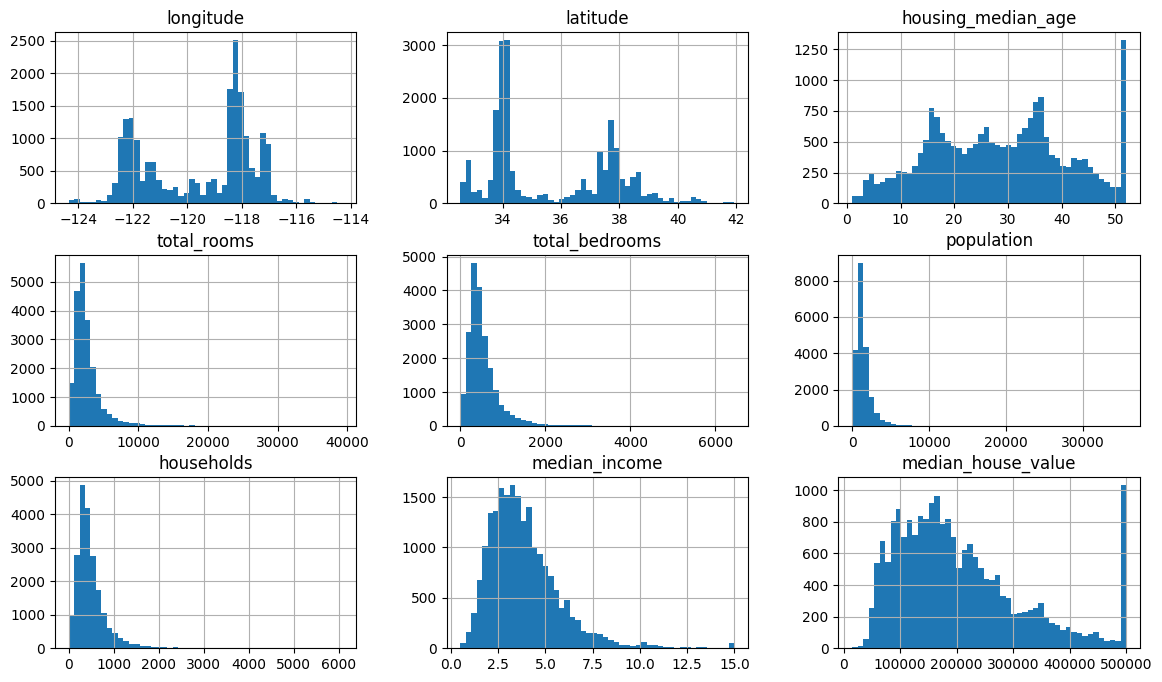

In [14]:
housing.hist(bins=50, figsize=(14, 8))
plt.show()

<p>Observations on these distributions:</p>
<ul>
    <li><code>median_income</code>: it does not seem to be in USD. It has been scaled and capped at <code>15</code> for higher median incomes and <code>0.5</code> for lower median incomes. The numbers represent <b>tens of thousands of USD</b>.</li>
    <li><code>median_house_age</code> and <code>median_house_value</code> have also been capped. Notice how the ending bins are disproportionally larger than the rest.</li>
        <ul>
            <li>The latter might be an issue, as it is our <b>target attribute</b>. If our team needs precise predictions beyond USD500,000m then we either:</li>
            <ul>
                <li>Collect proper labels for the capped districts.</li>
                <li>Remove capped districts from the dataset.</li>
            </ul>
        </ul>
    <li>There is an issue with <b>different scales</b>.</li>
    <li>Histograms are <b>rightly skewed</b>. This distribution may affect the abilities of ML to detect patterns.</li>
</ul>



<h2><font color="red"><b>WARNING!</b></font></h2>
Now it's the time to create a test set, put it aside, and <font color="dark red"><b>never look at it</b></font>!
<hr>
<h2>Create a <b>test set</b></h2>
<p>Basically, we need to pick <b>20%</b> of the dataset (this percentage may be smaller if the dataset is very large).</p>

In [15]:
def shuffle_and_split_data(data, test_ratio):
    """
    Shuffle the indices, split them into test and training sets based on a test ratio.
    """
    shuffled_indices = np.random.permutation(len(data)) # generate random permutation from 0 to length of data
    test_set_size = int(len(data) * test_ratio) # multiplies length of data by assigned percentage
    test_indices = shuffled_indices[:test_set_size] # assign the first elements
    train_indices = shuffled_indices[test_set_size:] # assign remaining indices
    return data.iloc[train_indices], data.iloc[test_indices]


In [16]:
train_set, test_set = shuffle_and_split_data(housing, 0.2)
len(train_set)

16512

In [17]:
len(test_set)

4128

<p>Using this code, every time we run our notebook, we'll get a different test set. This is not desirable, as we don't want to see the whole dataset. To avoid this behavior, we can set the random number generator's seed before calling <code>np.random.permutation()</code>.

In [18]:
np.random.seed(42)

<p>This will not work, however, after you get an updated dataset. Instead, you <i>can</i> do, instead, is to use each instance's identifier to decide if it should not go in the test set. This would require that instances have unique and immutable identifiers. For instance, we could compute a hash of each instance's id and put that instance in the test set if the hash is lower or equal to 20% of the max hash value. The test set will remain consistent across multiple runs even if the dataset is updated. The new test set will contain 20% of the new instances but it will not contain any instance that was previously in the training set.</p>

In [19]:
def is_id_in_test_set(identifier, test_ratio):
    return crc32(np.int64(identifier)) < test_ratio * 2**32


def split_data_with_id_hash(data, test_ratio, id_column):
    ids = data[id_column]
    in_test_set = ids.apply(lambda id_: is_id_in_test_set(id_, test_ratio))
    return data.loc[~in_test_set], data.loc[in_test_set]


<p>Because the dataset does not present an id column, we will use the row index as an id.</p>

In [20]:
housing_with_id = housing.reset_index() # adds an index column by keeping default drop=False

train_set, test_set = split_data_with_id_hash(housing_with_id, 0.2, "index")

<p>When you use this method, you must ensure that new data gets appended to the end of the dataset and that no row ever gets deleted. If this is not possible, using a stable feature - aka, one that does not change - is an alternative.In our case, a district's latitude and longitude could be used as unique ids:</p>

In [21]:
housing_with_id["id"] = housing["longitude"] * 1000 + housing["latitude"]

train_set, test_set = split_data_with_id_hash(housing_with_id, 0.2, "id")

<p>Scikit-Learn also provides a few functions that allow us to split datasets in different ways. <code>train_test_split()</code> does the same thing as our function <code>shuffle_and_split_data()</code> and includes a couple of additional features. You can use the parameter <code>random_state</code>, which allows you to set the random generator seed, just as we did with <code>np.random.seed()</code>. Also, you can also pass multiple datasets with an identical number of rows, and split them on the same indices:</p>

In [22]:
train_set, test_set = train_test_split(housing, test_size=0.2, random_state=42)

<p>If the dataset is large and has many attributes, a random sample is just fine. However, when this is not the case, we can run the risk of introducing a <b>sampling bias</b>. This is particularly true when the sample we are running must be representative of the entire population. For example, when conducting a survey, one must take into consideration the male-female ratio in a given country to avoid an over-representative sample. This is called <b>stratified sampling</b>: we divide the population into <b>strata</b>, and the right number of instances are sampled from each stratum to make sure that the test set is representative.</p>
<p>If we want to find the probability that a random sample of 1000 people conains less than 48.5% femail or more than 53.5% when the population's female ratio is 51.1%, we use the <b>binomial distribution</b>. The <code>cdf()</code> method of the binomial distribution gives us the probability that the number of females will be equal or less than the given value:</p>


In [23]:
from scipy.stats import binom

sample_size = 1000
ratio_female = 0.511
prob_too_small = binom(sample_size, ratio_female).cdf(485 - 1)
prob_too_large = 1 - binom(sample_size, ratio_female).cdf(535)
print(prob_too_small + prob_too_large)

0.10736798530929913


<p>Likewise, we can run a simulation to get a similar result:</p>

In [24]:
np.random.seed(42)

samples = (np.random.rand(100_000, sample_size) < ratio_female).sum(axis=1)
((samples < 485) | (samples > 535)).mean()

0.1071

<p>In our case, considering that the experts told us that the median income is a very important attribute to predict median housing prices, we want to be sure that the test set is representative of the various categories of incomes in the whole dataset. The median income is a <b>continuous, numerical</b> attribute and therefore we must create an <b>income category attribute</b>. </p>
<p>We know that most median income values are clustered around 1.6 to 6 (or &#36;15k to &#36;60k). We know, however, that some values fall below or above this interval. It is important to have a sufficient number of observations for each stratum, otherwise the estimate of a stratum's relevance may be biased. In other words, we should <b>not</b> have too many strata, and each strata should be <b>large enough</b>. We can use <code>pd.cut()</code> to create <b>five</b> categories with different ranges considering a 1.5 interval:</p>

In [25]:
housing["income_cat"] = pd.cut(housing["median_income"],
                               bins=[0., 1.5, 3.0, 4.5, 6., np.inf],
                               labels=[1, 2, 3, 4,5])

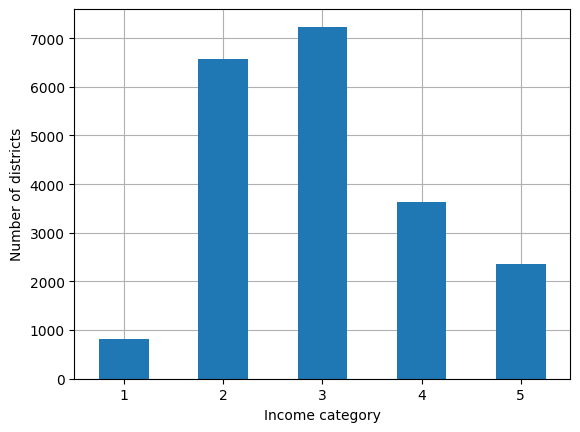

In [26]:
housing["income_cat"].value_counts().sort_index().plot.bar(rot=0, grid=True)

# adjust the zorder of the grid lines to be displayed behind the bars
plt.gca().set_axisbelow(True)

plt.xlabel("Income category")
plt.ylabel("Number of districts")
plt.show()


<p>This categorization allows us to do stratified sampling based on the income category. We can now do a stratified sampling based on this variable, and Scikit-Learn provides some splitter classes in the <code>sklearn.model_selection</code> package. Each of these has a <code>split()</code> method that returns an iterator over different training/test splits of the same data.</p>
<p><code>split()</code> actually yields the training and test <b>indices</b> and <i>not</i> the actual data. Splitting the dataset multiple times will be helpful in upcoming tasks. The following code generates 10 different stratified splits of the same dataset:</p>

In [27]:
from sklearn.model_selection import StratifiedShuffleSplit

splitter = StratifiedShuffleSplit(n_splits=10, test_size=0.2, random_state=42)
strat_splits = []

for train_index, test_index in splitter.split(housing, housing["income_cat"]):
    strat_train_set_n = housing.iloc[train_index]
    strat_test_set_n = housing.iloc[test_index]
    strat_splits.append([strat_train_set_n, strat_test_set_n])

<p>We just imported the class <code>StratifiedShuffleSplit</code> from the <code>sklearn.model_selection</code> package. Then, we created a variable <code>splitter</code> that uses this class, defining the number of splits, the proportion of the dataset to be used, and the randomness of the sample. We created an empty list to store the stratified splits. Following, we apply a for loop that passes the function <code>.split()</code>. which splits the dataset into a training and test set, returning their respective indices. They are assigned to different variables, which are then appended to the empty list as two different sets.</p>
<p>For now, we can use the first split only:</p>

In [28]:
strat_train_set, strat_test_set = strat_splits[0]

<p>We can also cut some slack and use <code>train_test_split()</code> with the stratify argument passed on it:</p>

In [29]:
strat_train_set, strat_test_set = train_test_split(housing, test_size=0.2, stratify=housing["income_cat"], random_state=42)

<p>To see if our code has worked properly, we can look at the income category proportions in the test set:</p>

In [30]:
strat_test_set["income_cat"].value_counts() / len(strat_test_set)

3    0.350533
2    0.318798
4    0.176357
5    0.114341
1    0.039971
Name: income_cat, dtype: float64

<p>By comparing these results with the bar chart, we can safely say that it has worked. We can also measure proportions in the full dataset:</p>

In [31]:
def income_cat_proportions(data):
    return data["income_cat"].value_counts() / len(data)

train_set, test_set= train_test_split(housing, test_size=0.2, random_state=42)

compare_props = pd.DataFrame({
    "Overall %": income_cat_proportions(housing),
    "Stratified %": income_cat_proportions(strat_test_set),
    "Random %": income_cat_proportions(test_set),
}).sort_index()

compare_props.index.name = "Income Category"
compare_props["Strat. Error %"] = (compare_props["Stratified %"] /
                                   compare_props["Overall %"] -1)
compare_props["Rand. Error %"] = (compare_props["Random %"] /
                                  compare_props["Overall %"] -1)

(compare_props * 100).round(2)


,Overall %,Stratified %,Random %,Strat. Error %,Rand. Error %
Income Category,,,,,
1,3.98,4.00,4.24,0.36,6.45
2,31.88,31.88,30.74,-0.02,-3.59
3,35.06,35.05,34.52,-0.01,-1.53
4,17.63,17.64,18.41,0.03,4.42
5,11.44,11.43,12.09,-0.08,5.63


<p>What do we get out of this comparison between stratified versus purely random sampling methods? Well, the test set that was created using the former has income category proportions <b>almost identical</b> to those in the overall dataset. The latter, meanwhile, returned <b>higher percentage errors</b>, which reflects the problem of purely random sampling returning skewed results.</p>
<p>Since we won't be using <code>income_cat</code> no more, we can go ahead and just drop it out of our dataset.</p>

In [32]:
for set_ in (strat_train_set, strat_test_set):
    set_.drop("income_cat", axis=1, inplace=True)

<p>Spending some time on test set generation is important, as it is often <b>neglected</b>. Also, those concepts will help us when discussing cross-validation. We can move on and explore our data!</p>
<hr>
<h2><b>Explore</b> and <b>Visualize</b> the Data to <b>Gain Insights</b>
<p><b>Goal</b>: to go into a little more depth and understand our dataset.</p>
<p>We should make some important notes here. First, we must be sure that we will be exploring <b>only</b> the <b>training set</b>. In addition, in case our set is too large, we must also <b>sample it</b>; we won't be doing this now, as our set is fairly small. Second, because we will be performing several manipulation procedures on our data, we should also <b>make a copy</b> of it and work on it.</p>


In [33]:
housing = strat_train_set.copy()

<h3>Visualizing <b>Geographical Data</b></h3>
<p>Let's create a scatterplot using the geographical information available in our dataset:</p>

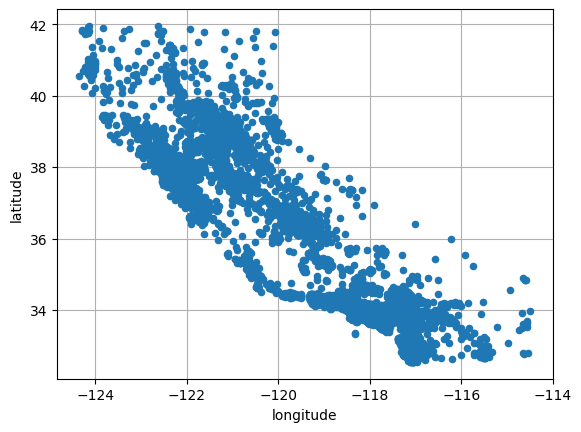

In [34]:
housing.plot(kind="scatter", x="longitude", y="latitude", grid=True)
plt.gca().set_axisbelow(True)

plt.show()

<p>To make our chart more meaningful, we can adjust some parameters of <code>.plot()</code>. Let's set <code>alpha</code> to <code>0.2</code> and move our grid to the back.</p>

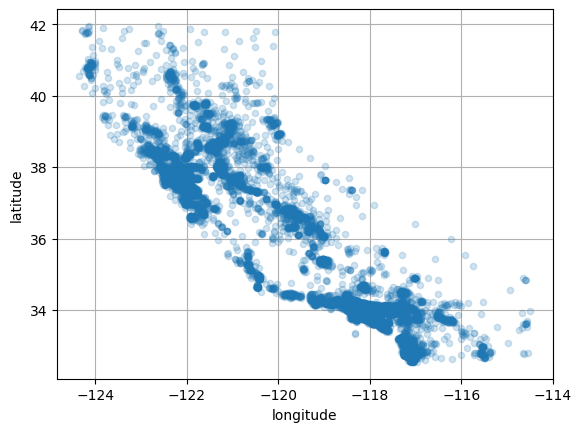

In [35]:
housing.plot(kind="scatter", x="longitude", y="latitude", grid=True, alpha=0.2)
plt.gca().set_axisbelow(True)
plt.show()

<p>We can now see the <b>high-density areas</b> such as Bay Area (around Los Angeles and San Diego), as well as other regions in the Central Valley (around Sacramento and Fresno).</p>
<p>We can refine our visualization even more. Let's add the median housing prices (represented by the color of each circle), as well as the population per district (represented by the radius of each circle):

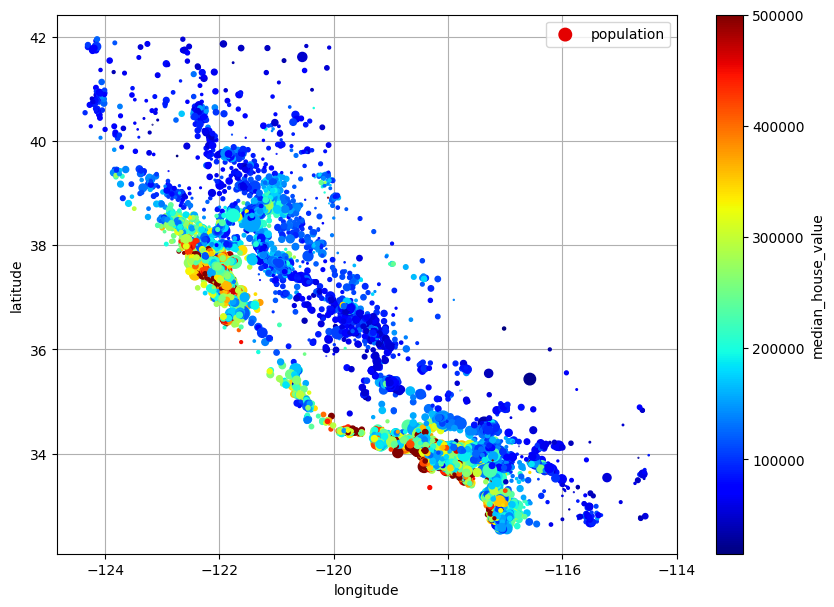

In [36]:
housing.plot(
    kind="scatter", x="longitude",
    y="latitude", grid=True,
    s=housing["population"] / 100,
    label="population",
    c="median_house_value", # color set by median house value
    cmap="jet", colorbar=True, # set color and show color bar
    legend=True, sharex=False,
    figsize=(10, 7)
)

plt.gca().set_axisbelow(True)
plt.show()

<p>As we can see, higher prices are related to <b>location</b> and to <b>population density</b>. Still, this is not always the case, as, in Northern California, prices are lower despite being near the ocean.</p>
<h3>Look for <b>Correlations</b></h3>
<p>As our dataset is not too large, we can use <code>.corr()</code> to compute the <b>standard correlation coefficient</b>.</p>
<p><b>Note</b>: the default method is <b>Pearson's r</b>, yet you can change it by passing a different method in the <code>method</code> parameter. You can pass <code>'pearson', 'kendall', 'spearman'</code> or another callable.

In [37]:
corr_matrix = housing.corr(numeric_only=True)

In [38]:
corr_matrix["median_house_value"].sort_values(ascending=False)

median_house_value    1.000000
median_income         0.688380
total_rooms           0.137455
housing_median_age    0.102175
households            0.071426
total_bedrooms        0.054635
population           -0.020153
longitude            -0.050859
latitude             -0.139584
Name: median_house_value, dtype: float64

<p>We can see a relatively higher positive correlation between the median house value and the median income (0.68), and a weak negative correlation between the median house value and the latitude, which means that prices go down as latitude goes up, for instance - but the correlation is very weak!</p>
<p>We can also use the Pandas <code>scatter_matrix()</code> function. It plots every numerical attribute against every other numerical variable. We can select relevant features that can hopefully show some correlation with the median housing value as follows:</p>

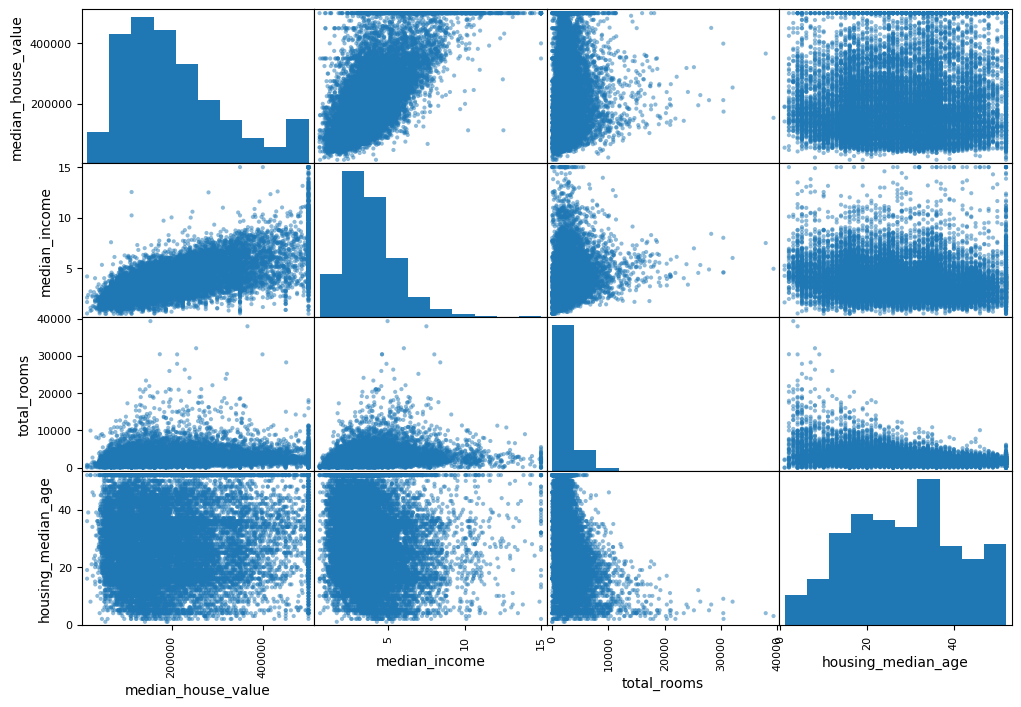

In [39]:
from pandas.plotting import scatter_matrix

attributes = [
    "median_house_value",
    "median_income",
    "total_rooms",
    "housing_median_age"
]

scatter_matrix(housing[attributes], figsize=(12, 8))
plt.show()

<p>Initially, we can observe a positive correlation between <code>median_income</code> and <code>median_house_value</code>. Let's plot a separate scatter plot for these two variables:</p>

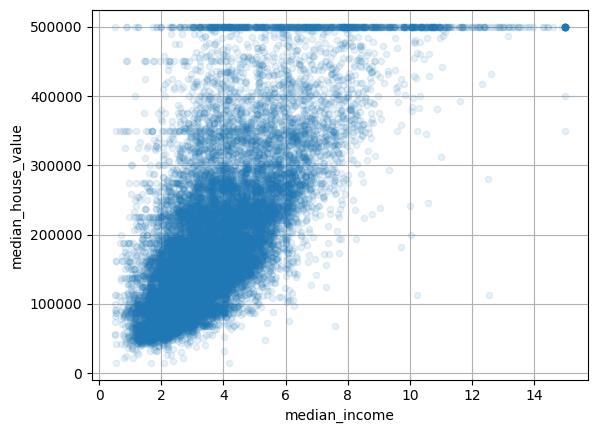

In [40]:
housing.plot(
    kind="scatter", x="median_income",
    y="median_house_value", alpha=0.1,
    grid=True
)

plt.gca().set_axisbelow(True)
plt.show()

<p>Observations:</p>
<ul>
    <li>There is a strong positive correlation between the two variables.</li>
    <li>We can see the price cap on <code>median_house_value</code> that we had pointed out before represented by the series of points along the &#36;500,000 value.</li>
    <li>We can also observe other <b>horizontal lines</b> around &#36;450,000, &#36;350,000, and maybe &#36;280,000. We may want to remove the corresponding districts to avoid reproducing this quirks when deploying our algorithms.</li>
</ul>
<h3>Experiment with <b>Attribute Combinations</b></h3>
<p>The last thing we can do before preparing the data for ML is to experiment with varius attribute combinations. For instance, while variables such as the number of rooms in a district or the number of bedrooms are not particularly useful by themselves, once combined with features such as the number of households, they can become quite relevant.</p>
<p>Let's create new attributes by combining some of our variables:</p>

In [41]:
housing["rooms_per_house"] = housing["total_rooms"] / housing["households"]
housing["bedrooms_ratio"] = housing["total_bedrooms"] / housing["total_rooms"]
housing["people_per_house"] = housing["population"] / housing["households"]

<p>We can now take a look at the correlation matrix once more:</p>

In [42]:
corr_matrix = housing.corr(numeric_only=True)
corr_matrix["median_house_value"].sort_values(ascending=False)

median_house_value    1.000000
median_income         0.688380
rooms_per_house       0.143663
total_rooms           0.137455
housing_median_age    0.102175
households            0.071426
total_bedrooms        0.054635
population           -0.020153
people_per_house     -0.038224
longitude            -0.050859
latitude             -0.139584
bedrooms_ratio       -0.256397
Name: median_house_value, dtype: float64

<p>We can observe that the new variable <code>bedrooms_ratio</code> returned a much stronger correlation with <code>median_house_value</code>. Houses with a loer bedroom/room ratio seem to be more expensive (negatively correlated). Remember, the goal here is not to explore <i>all</i> possible correlations: we want to get a gist of the dataset and find insights that will hint at the first steps towards setting up a first prototype. We can always go back to the exploration part of the project to gain more insights on it.</p>
<hr>
<h2><b>Prepare</b> the Data for ML Algorithms</h2>
<p>It's always a good practice, when preparing our data, to write <b>functions</b>, as you can apply them on other datasets, gradually build a library that can be reused in future projects, and use them in our live system to transform the new data before feeding it to algorithms. Moreover, we can try different transformation procedures and see which of them works best.</p>
<p>First, we can revert to a cleaning training and separate the predictors and te labels, as we don't want to apply the same transformations to the predictors and the target values:</p>


In [43]:
housing = strat_train_set.drop("median_house_value", axis=1)
housing_labels = strat_train_set["median_house_value"].copy()

<h3><b>Clean</b> the Data</h3>
<p>Our first task is to deal with <b>missing features</b>. We already noticed that <code>total_bedrooms</code> presented some missing values. As the book and the notebook presented three different approaches, let's try all of them here using copies of the original training set.</p>
<h4>Option 1. Get rid of the corresponding districts</h4>

In [44]:
# Create dataframe that displays NaN values for comparison purposes
null_rows_idx = housing.isnull().any(axis=1)
housing.loc[null_rows_idx].head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,ocean_proximity
14452,-120.67,40.50,15.0,5343.0,NaN,2503.0,902.0,3.5962,INLAND
18217,-117.96,34.03,35.0,2093.0,NaN,1755.0,403.0,3.4115,<1H OCEAN
11889,-118.05,34.04,33.0,1348.0,NaN,1098.0,257.0,4.2917,<1H OCEAN
20325,-118.88,34.17,15.0,4260.0,NaN,1701.0,669.0,5.1033,<1H OCEAN
14360,-117.87,33.62,8.0,1266.0,NaN,375.0,183.0,9.8020,<1H OCEAN


In [45]:
# Option 1
housing_option1 = housing.copy()
housing_option1.dropna(subset=["total_bedrooms"], inplace=True) # Drop all rows in which there are NaN values in column total_bedrooms
housing_option1.loc[null_rows_idx].head()


,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,ocean_proximity


<p>We dropped all rows with NaN values for <code>total_bedrooms</code>. Then, we used the <code>.loc</code> accessor to see if the null rows were in the DataFrame. This method eliminates the corresponding districts.</p>
<h4>Option 2. Get hid of the entire <code>total_bedrooms</code> variable.</h4>



In [46]:
housing_option2 = housing.copy()
housing_option2.drop("total_bedrooms", axis=1, inplace=True)
housing_option2.loc[null_rows_idx].head()

,longitude,latitude,housing_median_age,total_rooms,population,households,median_income,ocean_proximity
14452,-120.67,40.50,15.0,5343.0,2503.0,902.0,3.5962,INLAND
18217,-117.96,34.03,35.0,2093.0,1755.0,403.0,3.4115,<1H OCEAN
11889,-118.05,34.04,33.0,1348.0,1098.0,257.0,4.2917,<1H OCEAN
20325,-118.88,34.17,15.0,4260.0,1701.0,669.0,5.1033,<1H OCEAN
14360,-117.87,33.62,8.0,1266.0,375.0,183.0,9.8020,<1H OCEAN


<p>As we can see, the entire attribute was removed from the training set.</p>
<h4><b>(Selected)</b> Option 3. Set the missing values to a some value - <i>imputation</i>.
<p>We'll chose this option as it does not affect our dataset that much. Also, we will chose to fill empty values with the <b>median</b>, as it is robust to extreme values and will not generally affect that much our model as other measures such as the mean.</p>

In [47]:
housing_option3 = housing.copy()
median = housing["total_bedrooms"].median()
housing_option3["total_bedrooms"].fillna(median, inplace=True)

housing_option3.loc[null_rows_idx].head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,ocean_proximity
14452,-120.67,40.50,15.0,5343.0,434.0,2503.0,902.0,3.5962,INLAND
18217,-117.96,34.03,35.0,2093.0,434.0,1755.0,403.0,3.4115,<1H OCEAN
11889,-118.05,34.04,33.0,1348.0,434.0,1098.0,257.0,4.2917,<1H OCEAN
20325,-118.88,34.17,15.0,4260.0,434.0,1701.0,669.0,5.1033,<1H OCEAN
14360,-117.87,33.62,8.0,1266.0,434.0,375.0,183.0,9.8020,<1H OCEAN


<p>That's great! Yet, we can benefit from Scikit-Learn's <code>SimpleImputer</code>, a class that will store the median value for each feature. This will make it possible to impute NaN values on both sets or any new data fed to the model, hence saving us a lot of work during future iterations. To use this class, we must first create a <code>SimpleImputer</code> instance and define on the <code>strategy</code> parameter the value that we want to use as a replacement for missing values.</p>

In [48]:
from sklearn.impute import SimpleImputer

imputer = SimpleImputer(strategy="median")

<p>We'll then make a copy of the data containing only numerical variables, as the median can only be computed on such attributes.</p>

In [49]:
housing_num = housing.select_dtypes(include=[np.number])

<p>To fit <code>imputer</code> to the training data, we can use <code>fit()</code>
<hr>
<h4>The <code>fit()</code> method.
<p><b>In a nutshell</b>: fitting is equal to training. Then, after it is trained, the model can be used to make predictions, usually with a .predict() method call.</p>

<p><b>To elaborate</b>: Fitting your model to (i.e. using the .fit() method on) the training data is essentially the training part of the modeling process. It finds the coefficients for the equation specified via the algorithm being used (take for example umutto's linear regression example, above).</p>

Then, for a classifier, you can classify incoming data points (from a test set, or otherwise) using the predict method. Or, in the case of regression, your model will interpolate/extrapolate when predict is used on incoming data points.

It also should be noted that sometimes the "fit" nomenclature is used for non-machine-learning methods, such as scalers and other preprocessing steps. In this case, you are merely "applying" the specified function to your data, as in the case with a min-max scaler, TF-IDF, or other transformation.</p>
<hr>



In [50]:
imputer.fit(housing_num)

SimpleImputer(strategy='median')

<p>Here, the <code>imputer</code> computed the median of each variable and stored the result in a variable. We knew that only <code>total_bedrooms</code> registered NaN values, but missing data can appear when new data is stored once the system goes online. As a result, it is wise to apply the <code>imputer</code> to <b>all</b> numerical variables:</p>

In [51]:
imputer.statistics_

array([-118.51  ,   34.26  ,   29.    , 2125.    ,  434.    , 1167.    ,
        408.    ,    3.5385])

In [52]:
housing_num.median().values

array([-118.51  ,   34.26  ,   29.    , 2125.    ,  434.    , 1167.    ,
        408.    ,    3.5385])

<p>We can now use it to transform the training set by replacing missing values with the learned medians. This is a great way of keeping our dataset "in shape" whenever new data is plugged in.</p>

In [53]:
# Use .transform() to impute all missing values, in this case, with the median
X = imputer.transform(housing_num)

<p>Remember that you can also pass other replacements, such as the <b>mean</b>, <b>mode</b>, or a <b>constant</b>.

In [54]:
imputer.feature_names_in_

array(['longitude', 'latitude', 'housing_median_age', 'total_rooms',
       'total_bedrooms', 'population', 'households', 'median_income'],
      dtype=object)

In [55]:
housing_tr = pd.DataFrame(X, columns=housing_num.columns, index=housing_num.index)

In [56]:
housing_tr.loc[null_rows_idx].head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income
14452,-120.67,40.50,15.0,5343.0,434.0,2503.0,902.0,3.5962
18217,-117.96,34.03,35.0,2093.0,434.0,1755.0,403.0,3.4115
11889,-118.05,34.04,33.0,1348.0,434.0,1098.0,257.0,4.2917
20325,-118.88,34.17,15.0,4260.0,434.0,1701.0,669.0,5.1033
14360,-117.87,33.62,8.0,1266.0,434.0,375.0,183.0,9.8020


<p>Great! As we can see, the rows with null values have been updated and NaN values replaced with the median.</p>
<p>We can also notice that transformers, such as the <code>SimpleImputer</code> class, return NumPy arrays even when they are fed Pandas DataFrames as input. As such, the result of <code>imputer.transform(housing_num)</code> is a <b>NumPy array</b>, and <code>X</code> has no column nor index. We can wrap it in a DataFrame and get back the column names and index from housing_num:</p>

In [57]:
housing_tr = pd.DataFrame(X, columns=housing_num.columns, index=housing_num.index)

<b>Extra</b>: the author's Jupyter notebook suggests dropping some outliers. Let's follow along.

In [58]:
from sklearn.ensemble import IsolationForest

isolation_forest = IsolationForest(random_state=42)
outlier_pred = isolation_forest.fit_predict(X)

In [59]:
outlier_pred

array([-1,  1,  1, ...,  1,  1,  1])

<p>To drop extreme values, you could run the following code (we'll leave it commented):</p>

In [60]:
# housing = housing.iloc[outlier_pred == 1]
# housing_labels = housing_labels.iloc[outlier_pred == 1]

<h3>Handling <b>Text</b> and <b>Categorical</b> Attributes</h3>
<p>There is only one non-numerical feature in our dataset, <code>ocean_proximity</code>. Let's take a look at it:</p>

In [61]:
housing_cat = housing[["ocean_proximity"]]

In [62]:
housing_cat.head(8)

,ocean_proximity
13096,NEAR BAY
14973,<1H OCEAN
3785,INLAND
14689,INLAND
20507,NEAR OCEAN
1286,INLAND
18078,<1H OCEAN
4396,NEAR BAY


<p>We can clearly notice that we are dealing with a non-ordered, non-continuous set of non-numerical observations - a categorical variable. Because ML algorithms prefer working with <b>numbers</b>, we can convert these categories from <b>text</b> to <b>numbers</b>, a task we can easily accomplish with Scikit-Learn's <code>OrdinalEncoder</code> class:</p>

In [63]:
from sklearn.preprocessing import OrdinalEncoder

ordinal_encoder = OrdinalEncoder()
housing_cat_encoded = ordinal_encoder.fit_transform(housing_cat)

<p>This code will return encoded values for our categories:</p>

In [64]:
housing_cat_encoded[:8]

array([[3.],
       [0.],
       [1.],
       [1.],
       [4.],
       [1.],
       [0.],
       [3.]])

<p>To get the list of categories, use <code>categories_</code> as a variable instance. If you have more than one categorical variable, it will return a 1D array of categories for each of them (not our case, as we have only one categorical column):</p>

In [65]:
ordinal_encoder.categories_

[array(['<1H OCEAN', 'INLAND', 'ISLAND', 'NEAR BAY', 'NEAR OCEAN'],
       dtype=object)]

<p>We are dealing with a nominal, qualitative, unordered attribute. This means that nearby values do not translate into more similarity. ML algorithms by default <b>will</b> make this assumption. To fix this issue, a common solution is to create one <b>binary</b> attribute per category - one attribute equal to 1 when the category is <code>"INLAND"</code> and 0 otherwise. We will do this for every categorical value, a process named <b>one-hot encoding</b> because only <i>one</i> attribute will be equal to 1, the others being 0. These new features are often called <b>dummy variables</b>.</p>
<p>To make our job easier, Scikit-Learn provides a <code>OneHotEncoder</code> class to convert categorical values into dummy/one-hot vectors.</p>

In [66]:
from sklearn.preprocessing import OneHotEncoder

cat_encoder = OneHotEncoder()
housing_cat_1hot = cat_encoder.fit_transform(housing_cat)

In [67]:
housing_cat_1hot

<16512x5 sparse matrix of type '<class 'numpy.float64'>'
	with 16512 stored elements in Compressed Sparse Row format>

<p>The default output is a SciPy <i>sparse matrix</i> - a matrix that contains a large number of zero elements compared to the total number of elements in the matrix. Sparse matrices are an efficient way to represent zeros, as internally, they only store the nonzero values and their positions. We can use them like a normal 2d array, but if we want to convert any sparse matrix to a dense NumPy array, we can pass <code>.toarray()</code>.</p>

In [68]:
housing_cat_1hot.toarray()

array([[0., 0., 0., 1., 0.],
       [1., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0.],
       ...,
       [0., 0., 0., 0., 1.],
       [1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1.]])

<p>We could directly return a dense matrix by passing the argument <code>sparse_output=False</code> when creating <code>OneHotEncoder</code>. Be aware that the author's notebook still uses <code>sparse</code> as the parameter name, and if you're using version 1.2.2, your code will raise a warning.</p>



In [69]:
cat_encoder = OneHotEncoder(sparse_output=False)
housing_cat_1hot = cat_encoder.fit_transform(housing_cat)
housing_cat_1hot

array([[0., 0., 0., 1., 0.],
       [1., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0.],
       ...,
       [0., 0., 0., 0., 1.],
       [1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1.]])

<p>As with the <code>OrdinalEncoder</code>, it is possible to get the list of categories using the encoder's <code>categories_</code> variable.</p>

In [70]:
cat_encoder.categories_

[array(['<1H OCEAN', 'INLAND', 'ISLAND', 'NEAR BAY', 'NEAR OCEAN'],
       dtype=object)]

<p>In addition, you can get dummy variables in Pandas using <code>get_dummies()</code>.</p>

In [71]:
df_test = pd.DataFrame({
    "ocean_proximity": ["INLAND", "NEAR BAY"],
    }
)
pd.get_dummies(df_test)

,ocean_proximity_INLAND,ocean_proximity_NEAR BAY
0,1,0
1,0,1


<p><code>OneHotEncoder</code> presents the advantage of remembering which categories it was trained on. This is quite important, as once our model is in production, it should be fed <i>exactly</i> the same features as during training. We can notice the difference between the two methods when using <code>transform()</code> on <code>df_test</code>.</p>

In [72]:
cat_encoder.transform(df_test)

array([[0., 1., 0., 0., 0.],
       [0., 0., 0., 1., 0.]])

<p>And what is the difference between the two methods? Well, Pandas' <code>get_dummies</code> detected only <i>two</i> categories, returning two columns. <code>OneHotEncoder</code>, meanwhile, returned <i>one</i> column per <b>learned category</b>. In addition, while the former will always return a column no matter if an unknown category is fed, the latter will detect it and raise an <b>exception</b> (you can pass the <code>handle_unknown</code> hyperparameter as <code>ignore</code> if you want to, returning zeros).

In [73]:
df_test_unknown = pd.DataFrame({
    "ocean_proximity": ["<2H OCEAN", "ISLAND"],
    }
)
pd.get_dummies(df_test_unknown)
# cat_encoder_transform(df_test_uknown) # will raise an exception

,ocean_proximity_<2H OCEAN,ocean_proximity_ISLAND
0,1,0
1,0,1


In [74]:
cat_encoder.handle_unknown = "ignore"
cat_encoder.transform(df_test_unknown)

array([[0., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0.]])

<p><code>cat_encoder</code> smartly returns a 2D array that considers the 5 original categories of the dataset. As <code>"<2H OCEAN"</code> is not in it, it returned zeros for all columns. Very nice!</p>
<hr>
<h4><b>TIP</b> | Categorical Attributes with Too Many Categories </h4>
<p>If you have a category such as country or profession, one-hot encoding will result in a <b>large number of inputs</b>. In this case, it is a good idea to replace the categorical input with useful <b>numerical features</b>, such as a country's population.</p>
<hr>
<p>When you fit any Scikit-Learn estimator using a DataFrame, the estimator stores the column names in the <code>feature_names_in</code> variable; it makes sure that any DataFrame fed to this estimator has the same column names. Transformers, in addition, provide a <code>get_feature_names_out()</code> that you can use to build a DataFrame around the transformer's output.</p>

In [75]:
cat_encoder.feature_names_in_

array(['ocean_proximity'], dtype=object)

In [76]:
cat_encoder.get_feature_names_out()

array(['ocean_proximity_<1H OCEAN', 'ocean_proximity_INLAND',
       'ocean_proximity_ISLAND', 'ocean_proximity_NEAR BAY',
       'ocean_proximity_NEAR OCEAN'], dtype=object)

In [77]:
df_output = pd.DataFrame(cat_encoder.transform(df_test_unknown),
                         columns=cat_encoder.get_feature_names_out(),
                         index=df_test_unknown.index)

In [78]:
df_output

,ocean_proximity_<1H OCEAN,ocean_proximity_INLAND,ocean_proximity_ISLAND,ocean_proximity_NEAR BAY,ocean_proximity_NEAR OCEAN
0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,1.0,0.0,0.0


<h3><b>Feature Scaling</b> and <b>Transformation</b></h3>
<p>This is a <i>very important</i> topic. Most ML algorithms don't perform well when the input <b>numerical variables</b> have very different <b>scales</b>. In our case, for instance, the total number of rooms ranges from:

In [79]:
print(f"Min number of rooms: {int(housing['total_bedrooms'].min())}\nMax number of rooms: {int(housing['total_bedrooms'].max())} ")

Min number of rooms: 1
Max number of rooms: 6210 


<p>The median income, meanwhile, ranges from 0 to 15:</p>

In [80]:
print(f"Min median income: {int(housing['median_income'].min())}\nMax median income: {int(housing['median_income'].max())} ")

Min median income: 0
Max median income: 15 


<p>If no scaling is applied, our model will be biased, ignoring the median income and focusing on the number of rows. To get all attributes in the same scale, we can use two ways: <i>min-max scaling</i> and <i>standardization</i>.
<p><b>Min-max scaling</b>. For each attribute, the values are shifted and rescaled, so that they range from <code>0</code> to <code>1</code>. You can use <code>MinMaxScaler</code>, available on Scikit-Learn, to transform the values. You can even change the range of the features with <code>feature_range</code>.</p>

In [81]:
from sklearn.preprocessing import MinMaxScaler

min_max_scaler = MinMaxScaler(feature_range=(-1, 1))
housing_num_min_max_scaled = min_max_scaler.fit_transform(housing_num)

In [82]:
housing_num_min_max_scaled

array([[-0.60851927,  0.11702128,  1.        , ..., -0.80701754,
        -0.61433638, -0.7794789 ],
       [ 0.21095335, -0.66170213,  0.52941176, ..., -0.91866029,
        -0.86708979, -0.22929339],
       [-0.51926978,  0.23617021,  0.25490196, ..., -0.93141946,
        -0.92458466, -0.73336919],
       ...,
       [ 0.47870183, -0.99148936, -0.52941176, ..., -0.65513434,
        -0.71663244, -0.50873781],
       [ 0.20689655, -0.6787234 ,  0.41176471, ..., -0.78873758,
        -0.68751167, -0.49716556],
       [-0.60649087,  0.08723404,  0.68627451, ..., -0.91669734,
        -0.92122457, -0.61608805]])

<p><b>Standardization</b>. This method <i>subtracts</i> the <b>mean</b> value (so that standardized values have a <b>zero</b> mean), then it <i>divides</i> the result by the <b>standard deviation</b> (so that they have a standard deviation of <b>1</b>). Because they are not restricted to a specific range, you cannot set a min-max range. However, standardization is not as sensitive to extreme values. Scikit-Learn also provides a transformer for this task, <code>StandardScaler</code>.</p>

In [83]:
from sklearn.preprocessing import StandardScaler

std_scaler = StandardScaler()
housing_num_std_scaled = std_scaler.fit_transform(housing_num)

In [84]:
housing_num_std_scaled

array([[-1.42303652,  1.0136059 ,  1.86111875, ...,  0.13746004,
         1.39481249, -0.93649149],
       [ 0.59639445, -0.702103  ,  0.90762971, ..., -0.69377062,
        -0.37348471,  1.17194198],
       [-1.2030985 ,  1.27611874,  0.35142777, ..., -0.78876841,
        -0.77572662, -0.75978881],
       ...,
       [ 1.25620853, -1.42870103, -1.23772062, ...,  1.26829911,
         0.67913534,  0.1010487 ],
       [ 0.58639727, -0.73960483,  0.66925745, ...,  0.27356264,
         0.88286825,  0.14539615],
       [-1.41803793,  0.94797769,  1.22545939, ..., -0.67915557,
        -0.75221898, -0.31034135]])

<p>In case we are dealing with a distribution that has a <b>heavy tail</b>, with values far from the mean being not exponentially rare, both methods will squash most values into a small range, which will subsequently affect ML models. It is a good idea to replicate the author's charts, which exemplify the process.</p>


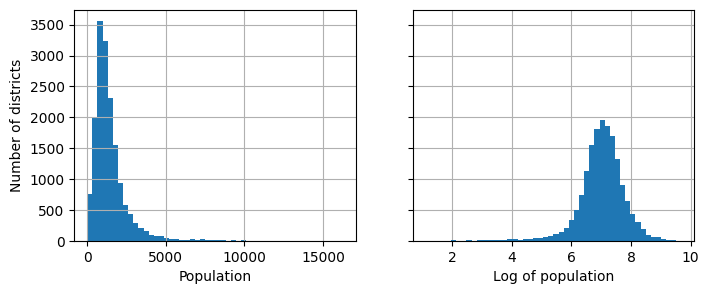

In [85]:
fig, axs = plt.subplots(1, 2, figsize=(8, 3), sharey=True)
housing["population"].hist(ax=axs[0], bins=50)
housing["population"].apply(np.log).hist(ax=axs[1], bins=50)
axs[0].set_xlabel("Population")
axs[1].set_xlabel("Log of population")
axs[0].set_ylabel("Number of districts")

plt.gca().set_axisbelow(True)
plt.show()

<p>This method worked because the distribution of the population closely follows a <b>power law distribution</b>: districts with 10,000 inhabitants, for instance, are only 10 times <i>less</i> frequent than districts with 1,000 inhabitants. They are not <i>exponentially</i> less frequent. The result of this transformation resembles a Gaussian distribution.</p>
<p>You can also use <b>bucketizing</b> the feature as an alternative approach. It consists of chopping the variable's distribution into reoughly equal-sized buckets and replacing each feature value with the <b>index</b> of the bucket it belongs to. We could then replace each value with its percentile. The code below demonstrates the change in the distribution.</p>

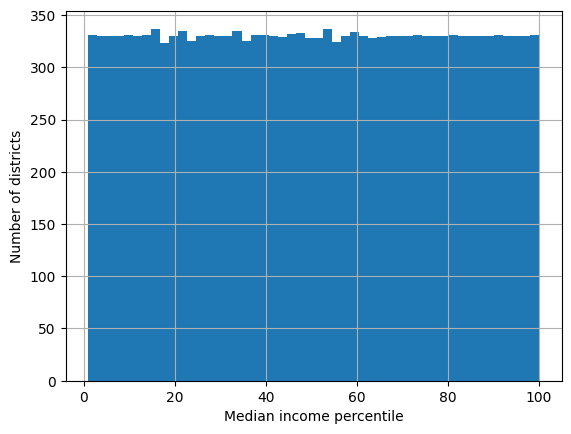

In [86]:
percentiles = [np.percentile(housing["median_income"], p)
               for p in range(1, 100)]
flattened_median_income = pd.cut(housing["median_income"],
                                 bins=[-np.inf] + percentiles + [np.inf],
                                 labels=range(1, 100 +1))
flattened_median_income.hist(bins=50)
plt.xlabel("Median income percentile")
plt.ylabel("Number of districts")

plt.show()

<p>Here, we bucketized the feature with equal-sized buckets, which resulted in an almost <b>uniform</b> distribution.</p>
<p>In case of a <b>multimodal distribution</b> (with two or more clear peaks, or <b>modes</b>), is to add a feature for each of the modes, representing the similarity between the housing median age and that particular mode. This similarity is often computed using a <b>radial basis function (RBF)</b> - any function that depends on the distance between the input value and a fixed point. We can use the <b>Gaussian RBF</b>, whose output value <b>decays exponentially</b> as the input value moves away from the fixed point.</p>
<p>Example: consider a housing age $x$ - its Gaussian RBF similarity between 35 will be given by the equation $exp(-y(x-35)^2)$. $y$ determines how quickly the similarity measure decays as $x$ moves away from 35.</p>
<p>We can use <code>rbf_kernel()</code> to create a new Gaussian RBF feature that measures the similarity between the housing median age and 35.</p>

In [87]:
from sklearn.metrics.pairwise import rbf_kernel
age_simil_35 = rbf_kernel(housing[["housing_median_age"]], [[35]], gamma=0.1)

<p>Next, we can visualize this new feature over the distribution of the housing median age. Let's replicate the author's code for this figure.</p>

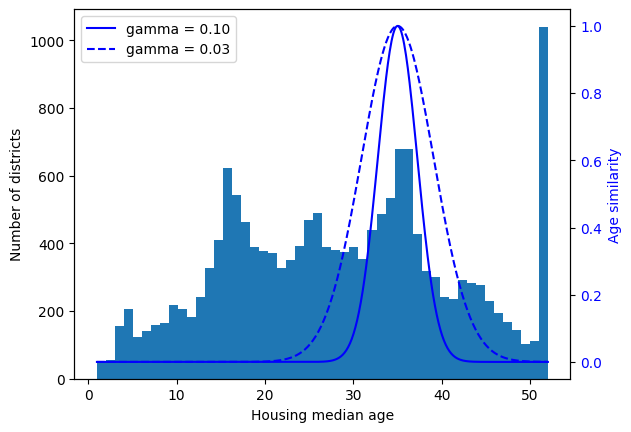

In [88]:
ages = np.linspace(housing["housing_median_age"].min(),
                   housing["housing_median_age"].max(),
                   500).reshape(-1, 1)

gamma1 = 0.1
gamma2 = 0.03
rbf1 = rbf_kernel(ages, [[35]], gamma=gamma1)
rbf2 = rbf_kernel(ages, [[35]], gamma=gamma2)

fig, ax1 = plt.subplots()
ax1.set_xlabel("Housing median age")
ax1.set_ylabel("Number of districts")
ax1.hist(housing["housing_median_age"], bins=50)

ax2 = ax1.twinx() # create a twin axis that shares the same x-axis
color = "blue"
ax2.plot(ages, rbf1, color=color, label="gamma = 0.10")
ax2.plot(ages, rbf2, color=color, label="gamma = 0.03", linestyle="--")
ax2.tick_params(axis="y", labelcolor=color)
ax2.set_ylabel("Age similarity", color=color)

plt.legend(loc="upper left")
plt.show()

<p>Here, we can see this new feature as a function of the housing median age, represented by the solid line. With a smaller <code>gamma</code>, it would look like the dashed line. We can see how the new age similarity peaks at 35, right around the housing median age distribution spike. If there is a good correlation with lower prices, this new feature might come in handy.</p>
<p>We might need to transform the <b>target values</b> too if it has a heavy tail. This will make our model predict the $log$ of the median house value, and that is not what we want. Fortunately, Scikit-Learn also provides an <code>inverse_transform()</code> method that will assist on computing the inverse of a transformation, returning the original scale. Let's see this in action in the following code.</p>

In [89]:
from sklearn.linear_model import LinearRegression

target_scaler = StandardScaler()
scaled_labels = target_scaler.fit_transform(housing_labels.to_frame())

model = LinearRegression()
model.fit(housing[["median_income"]], scaled_labels)
some_new_data = housing[["median_income"]].iloc[:5] # pretend this is new data

scaled_predictions = model.predict(some_new_data)
predictions = target_scaler.inverse_transform(scaled_predictions)

In [90]:
predictions

array([[131997.15275877],
       [299359.35844434],
       [146023.37185694],
       [138840.33653057],
       [192016.61557639]])

<p>What just happened? We used <code>StandardScaler</code> to scale the labels (we had done that in our inputs). Then, we trained a simple linear regression using such labels, which we used to make predictions on <code>some_new_data</code>. Following, we transformed the values back to the original scaler using <code>inverse_transform()</code>. Because the <code>StandardScaler</code> expects 2D inputs, we converted the Series to a DataFrame using <code>to_frame()</code>.</p>
<p>We could also use <code>TransformedTargetRegressor</code>, a simpler alternative.

In [91]:
from sklearn.compose import TransformedTargetRegressor

model = TransformedTargetRegressor(LinearRegression(),
                                   transformer=StandardScaler())
model.fit(housing[["median_income"]], housing_labels)
predictions = model.predict(some_new_data)

In [92]:
predictions

array([131997.15275877, 299359.35844434, 146023.37185694, 138840.33653057,
       192016.61557639])

<p>This time, we passed as arguments the regression models and the label transformer. We fit the model on the training set, using the original unscaled labels. The regressor will automatically use the transformer to scale the labels and train the regression model on the returned scaled labels. It will then predict the values, which will be returned with an inverse transformation.</p>
<h3><b>Custom</b> Transformers</h3>
<p>Writing custom transformers is an expected routine in ML, as we need to assess each dataset as a different case with, probably, specific needs in terms of cleanup operations, for instance.</p>
<p>For transformations with no need for some kind of training, you can write a function that takes a NumPy array as input and returns the transformed array. We can apply this method to transform features with heavy-tailed distributions by replacing them with their logarithm (considering that the variable is positive and is right-tailed).</p>

In [93]:
from sklearn.preprocessing import FunctionTransformer

log_transformer = FunctionTransformer(np.log, inverse_func=np.exp)
log_pop = log_transformer.transform(housing[["population"]])

<p>Here, the <code>inverse_func</code> argument is option. We can use it in case we want to specify an inverse transformation function. We can also pass hyperparameters. For instance, we can create a transformer that computes the same Gaussian RBF similarity measure that we did before.</p>

In [94]:
rbf_transformer = FunctionTransformer(rbf_kernel,
                                       kw_args=dict(Y=[[35.]], gamma=0.1))
age_simil_35 = rbf_transformer.transform(housing[["housing_median_age"]])

In [95]:
age_simil_35

array([[2.81118530e-13],
       [8.20849986e-02],
       [6.70320046e-01],
       ...,
       [9.55316054e-22],
       [6.70320046e-01],
       [3.03539138e-04]])

<p>There is no inverse function for <code>rbf_kernel()</code>, which, moreover, does not treat features separately. This means that an array with two features will be measured using a 2D distance. Here's how to add a feature that will measure the geographic similarity between each district and San Francisco.</p>

In [96]:
sf_coords = 37.7749, -122.41
sf_transformer = FunctionTransformer(rbf_kernel,
                                     kw_args=dict(Y=[sf_coords], gamma=0.1))
sf_simil = sf_transformer.transform(housing[["latitude", "longitude"]])

In [97]:
sf_simil

array([[0.999927  ],
       [0.05258419],
       [0.94864161],
       ...,
       [0.00388525],
       [0.05038518],
       [0.99868067]])

<p>When using custom transformers, we can also combine features.</p>

In [98]:
np.array([[1., 2.], [3., 4.]])

array([[1., 2.],
       [3., 4.]])

In [99]:
ratio_transformer = FunctionTransformer(lambda X: X[:, [0]] / X[:, [1]])
ratio_transformer.transform(np.array([[1., 2.], [3., 4.]]))

array([[0.5 ],
       [0.75]])

Let's break down the code snippet step by step:
<ol>
<li>First, the code defines a variable called <code>ratio_transformer</code> and assigns it a value. This value is an instance of the <code>FunctionTransformer</code> class.</li>

<li>The <code>FunctionTransformer</code> class is a utility class from the scikit-learn library that allows you to apply a specific function to each row or column of a dataset. In this case, the function being applied is a lambda function.</li>

<li>The lambda function takes an input X and performs an operation on it. In this case, <code>X[:, [0]] / X[:, [1]]</code> is being calculated. Let's break it down further:
<ul>
<li><code>X[:, [0]]</code> selects all rows (:) and the first column ([0]) from the input X array.</li>
<li><code>X[:, [1]]</code> selects all rows (:) and the second column ([1]) from the input X array.</li>
<li>The / operator divides the two selected columns element-wise.</li>
So, the lambda function essentially calculates the ratio between the elements of the first column and the elements of the second column in the input array X.
</li>
</ul>
<li>The <code>ratio_transformer.transform(np.array([[1., 2.], [3., 4.]]))</code> line applies the transformation defined by the ratio_transformer to the given input array <code>np.array([[1., 2.], [3., 4.]])</code>.
<ul>
<li>The input array <code>np.array([[1., 2.], [3., 4.]])</code> is a 2D NumPy array with two rows and two columns.</li>
<li>The transform method of the <code>ratio_transformer</code> object applies the transformation to the input array.</li>
<li>The result of the transformation is the ratio of the elements in the first column divided by the elements in the second column. In this case, it would be <code>array([[0.5], [0.75]])</code>.</li>
</ol>
<p>We can also create a custom class if we want our transformer to be trainable. Let's take a look at how to do it below.</p>

In [100]:
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.utils.validation import check_array, check_is_fitted

class StandardScalerClone(BaseEstimator, TransformerMixin):
    def __init__(self, with_mean=True): # no *args or **kwargs here!
        self.with_mean = with_mean

    def fit(self, X, y=None): #  y is required even if we don't use it
        X = check_array(X) # checks that X is an array with finite float values
        self.mean_ = X.mean(axis=0)
        self.scale_ = X.std(axis=0)
        self.n_features_in_ = X.shape[1] # every estimator stores this in fit()
        return self # always return self

    def transform(self, X):
        check_is_fitted(self) # looks for learned attributes (with trailing _)
        X = check_array(X)
        assert self.n_features_in_ == X.shape[1]
        if self.with_mean:
            X = X - self.mean_
        return X / self.scale_

<p>Our custom class is doing the same as a <code>StandardScaler</code>.  We use <code>TransformerMixin</code> as a base class to get <code>fit_transform()</code>, which we use together with <code>fit()</code> and <code>transform()</code>. This class will call the former and then the latter. When adding <code>BaseEstimator</code>, you get two methods, <code>get_params()</code> and <code>set_params()</code>.</p>

In [101]:
from sklearn.cluster import KMeans
class ClusterSimilarity(BaseEstimator, TransformerMixin):
    def __init__(self, n_clusters=10, gamma=1.0, random_state=None):
        self.n_clusters = n_clusters
        self.gamma = gamma
        self.random_state = random_state

    def fit(self, X, y=None, sample_weight=None):
        self.kmeans_ = KMeans(self.n_clusters,
                              random_state=self.random_state)
        self.kmeans_.fit(X, sample_weight=sample_weight)

        return self # always return self

    def transform(self, X):
        return rbf_kernel(X, self.kmeans_.cluster_centers_,
                          gamma=self.gamma)

    def get_features_names_out(self, names=None):
        return [f"Cluser {i} similarity" for i in range(self.n_clusters)]

<hr>
<h4><b>TIP</b> | Checking Custom Estimators </h4>
<p>You can ensure that your custom estimator is in line with Scikit-Learn's API by passing an instance to <code>check_estimator()</code> from the package <code>sklearn.utils.estimator_checks</code>.</p>
<hr>
<p><code>k-means</code> is a <b>clustering</b> algorithm that locates clusters in the data. What does it do?</p>
<ul>
    <li>Searches the number of clusters set by <code>n_clusters</code>.</li>
    <li>These will become available via the <code>cluster_centers_attribute</code>.</li>
    <li>The <code>fit()</code> method allows for <code>sample_weight()</code>, which lets you specify the relative weights of the samples.</li>
    <li><code>k-means</code> is a <b>stochastic</b> algorithm, that is, an algorithm that incorporates <b>random or probabilistic elements</b> in its execution, therefore introducing randomness and producing different outpus (unlike deterministic algorithms). To get reproducible results, you must set the <code>random_state</code> parameter.</li>
</ul>
<p>Let's apply this transformer in our case study.</p>


In [102]:
cluster_simil = ClusterSimilarity(n_clusters=10, gamma=1., random_state=42)
similarities = cluster_simil.fit_transform(housing[["latitude", "longitude"]],
                                           sample_weight=housing_labels)

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


<p>We get a <code>Clustersimilarity</code> transformer, setting a number of <code>10</code> clusters. We then call <code>fit_transform()</code> with the coordinates of every district in the training set, each of them being weighted by its median house value. The transformer uses <code>k-means</code> to locate the clusters, which are measured by the Gaussian RBF similarity between each district and all 10 cluster centers. We get a <b>matrix</b> with one row per district, and one column per cluster.</p>

In [103]:
similarities[:3].round(2)

array([[0.  , 0.14, 0.  , 0.  , 0.  , 0.08, 0.  , 0.99, 0.  , 0.6 ],
       [0.63, 0.  , 0.99, 0.  , 0.  , 0.  , 0.04, 0.  , 0.11, 0.  ],
       [0.  , 0.29, 0.  , 0.  , 0.01, 0.44, 0.  , 0.7 , 0.  , 0.3 ]])

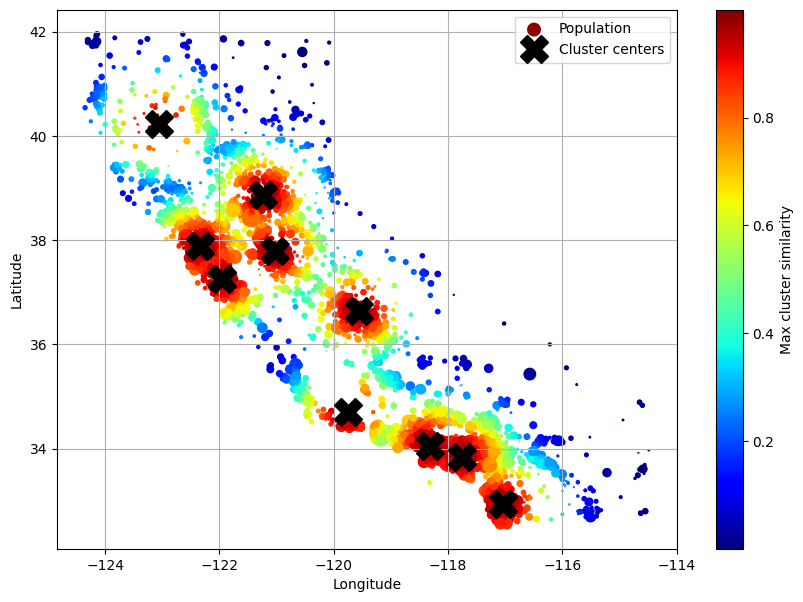

In [104]:
housing_renamed = housing.rename(columns={
    "latitude": "Latitude",
    "longitude": "Longitude",
    "population": "Population",
    "median_house_value": "Median house value (usd)"
})
housing_renamed["Max cluster similarity"] = similarities.max(axis=1)

housing_renamed.plot(kind="scatter", x="Longitude", y="Latitude", grid=True,
                     s=housing_renamed["Population"] / 100, label="Population",
                     c="Max cluster similarity",
                     cmap="jet", colorbar=True,
                     legend=True, sharex=False, figsize=(10, 7))
plt.plot(cluster_simil.kmeans_.cluster_centers_[:, 1],
         cluster_simil.kmeans_.cluster_centers_[:, 0],
         linestyle="", color="black", marker="X", markersize=20,
         label="Cluster centers")
plt.legend(loc="upper right")

plt.show()

<p>This is a <i>very</i> interesting figure that represents the utility of clustering our dataset using $k$-means. The districts are colored according to their geografic similarity to their closest cluster center - warmer tones represent this higher similarity. Moreover, we can see that clusters are located in densely populated areas.</p>
<h3>Transformation <b>Pipelines</b></h3>
<p>As there are many steps involved in data transformation, Scikit-Learn provides a <code>Pipeline</code> that assists us on those tasks. Here follows a simple pipeline for numerical variables.</p>

In [105]:
from sklearn.pipeline import Pipeline

num_pipeline = Pipeline([
    ("impute", SimpleImputer(strategy="median")),
    ("standardize", StandardScaler()),
])

<p>It takes a list of name/estimator pairs that define a sequence of steps. They can have any name (don't use double underscores, though) and must all be transformers, except for the last pair, which can be any other type of estimator.</p>
<hr>
<h4><b>TIP</b> | Rendering Interactive Diagrams of your Estimators</h4>
<p>You can render interactive diagrams to visualzie pipleines by running the following code and in a particular cell, as a last code line, running <code>num_pipeline</code> (or any variable name that you use to assign the config).</p>
<hr>

In [106]:
from sklearn import set_config

set_config(display="diagram")

num_pipeline

Pipeline(steps=[('impute', SimpleImputer(strategy='median')),
                ('standardize', StandardScaler())])

You can also import <code>make_pipeline()</code> in case you don't want to name the transformers.

In [107]:
from sklearn.pipeline import make_pipeline

num_pipeline = make_pipeline(SimpleImputer(strategy="median"), StandardScaler())

<p>Be aware that pipelines consider the <b>sequence</b> of estimators. For instance, here, we provided a transformer as the last estimator (<code>StandardScaler</code>). Hence, the pipeline also acts as a transformer, applying all the transformations to the data after the median value was imputed.</p>
<p>We can call the pipeline's <code>fit_transform()</code> method and lookt at the output fo the first two rows.</p>

In [108]:
housing_num_prepared = num_pipeline.fit_transform(housing_num)
housing_num_prepared[:2].round(2)

array([[-1.42,  1.01,  1.86,  0.31,  1.37,  0.14,  1.39, -0.94],
       [ 0.6 , -0.7 ,  0.91, -0.31, -0.44, -0.69, -0.37,  1.17]])

<p>You can use <code>get_feature_names_out()</code> to retrieve a DataFrame.</p>

In [109]:
df_housing_num_prepared = pd.DataFrame(housing_num_prepared, columns=num_pipeline.get_feature_names_out(),
                                       index=housing_num.index)

In [110]:
df_housing_num_prepared.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income
13096,-1.423037,1.013606,1.861119,0.311912,1.368167,0.137460,1.394812,-0.936491
14973,0.596394,-0.702103,0.907630,-0.308620,-0.435925,-0.693771,-0.373485,1.171942
3785,-1.203098,1.276119,0.351428,-0.712240,-0.760709,-0.788768,-0.775727,-0.759789
14689,1.231216,-0.884924,-0.919891,0.702262,0.742306,0.383175,0.731375,-0.850281
20507,0.711362,-0.875549,0.589800,0.790125,1.595753,0.444376,1.755263,-0.180365


<hr>
<h4><b>TIP</b>
<p>The following codes show us how you can learn more about how your pipelines are applied using interactive diagrams.</p>
<hr>

In [111]:
num_pipeline.steps

[('simpleimputer', SimpleImputer(strategy='median')),
 ('standardscaler', StandardScaler())]

In [112]:
num_pipeline[1]

StandardScaler()

In [113]:
num_pipeline.named_steps["simpleimputer"]

SimpleImputer(strategy='median')

In [114]:
num_pipeline.set_params(simpleimputer__strategy="median")

Pipeline(steps=[('simpleimputer', SimpleImputer(strategy='median')),
                ('standardscaler', StandardScaler())])

<p>Now, we can make our job easier and create a single transformer that deals with all columns. To accomplish this, we use <code>ColumnTransformer</code> - it will apply <code>num_pipeline</code> to numerical features and <code>cat_pipeline</code> to categorical ones.</p>

In [115]:
from sklearn.compose import ColumnTransformer

# Define list of numerical and categorical variables
num_attribs = ["longitude", "latitude", "housing_median_age", "total_rooms",
               "total_bedrooms", "population", "households", "median_income"]
cat_attribs = ["ocean_proximity"]

# Construct pipeline for categorical variables
cat_pipeline = make_pipeline(
    SimpleImputer(strategy="most_frequent"),
    OneHotEncoder(handle_unknown="ignore")
)

# Construct a ColumnTransformer
preprocessing = ColumnTransformer([
    ("num", num_pipeline, num_attribs),
    ("cat", cat_pipeline, cat_attribs)
])

<p>Requirements for <code>ColumnTransformer</code>:
<ul>
    <li>You must pass a list of <b>3-tuples</b>.</li>
    <li>The first is a <b>name</b>, which must be unique and not contain any double underscores).</li>
    <li>The second is a <b>transformer</b>.</li>
    <li>The third is a <b>list of names</b> to which the transformer will be applied.</li>
</ul>
<p>Some models may use many columns, hence listing all the column names can become tiresome and inefficient. Fortunately, we can use <code>make_column_selector()</code>, which you can pass to <code>ColumnTransformer</code> instead of names or indices. You can even pass <code>make_column_transformer()</code> in case you don't want to name the transformers.</p>

In [116]:
from sklearn.compose import make_column_selector, make_column_transformer

# Will return "pipeline-1" and "pipeline-2" instead of "num" and "cat"
preprocessing = make_column_transformer(
    (num_pipeline, make_column_selector(dtype_include=np.number)),
    (cat_pipeline, make_column_selector(dtype_include=object)),
)

<p>Now, we apply this transformer to our data.</p>

In [117]:
housing_prepared = preprocessing.fit_transform(housing)

<p>What did just happen?